# Stochastic analysis of time series

algorithm by "Analysis of time series from stochastic processes" by J.Gradisek, S.Riegert, R.Freidrich, I.Grabec [1]

In [108]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

## 1. Drift and Diffusion coefficients

They are defined in \[1\](4) as

$$
D^{(1)}_{i} = \lim_{\tau \to 0} \frac{1}{\tau} < X_i(t + \tau) - x_i >_{X(t) = \vec{x}}
\\
D^{(2)}_{ij} = \lim_{\tau \to 0} \frac{1}{\tau} < (X_i(t + \tau) - x_i)(X_j(t + \tau) - x_j) >_{X(t) = \vec{x}}
$$

In case of HO they write:
$$
D^{(1)}_{x} = \lim_{\tau \to 0} \frac{1}{\tau} < x(t + \tau) - x(t) >
\\
D^{(1)}_{v} = \lim_{\tau \to 0} \frac{1}{\tau} < v(t + \tau) - v(t) >
$$

As there are no limes-funcitons implemented, we will use the value of $D^{(i)}$ where $\tau$ equals the smallest possible value. Thus $\tau$ needs to be a integer value greater than 0, $\tau$ will be assumed as 1: $\lim_{\tau \to 0} \tau = 1$

In [120]:
def D_1(s, i, x, tau=1, bins=25):
    '''Retrieving Drift-Coefficient
    
    Parameters:
        - (array like)[2] s: (Array of arrays of float) time series.
            multiple dimensions possible
        - (int) i: index of dimension, which time series s[i] shall be examined.
        - (array like)[2] x: (Array of array of float) initial values at time t.
        - (int) tau: timestep
        - (float) bins: defines the threshold
        
    Usage:
        >>> D_1([x, v], 0, [ax, 0], tau=1, bins=25)
        >>> [D_1([x, v], 0, [ax, 0], tau=1, bins=10) for ax in arx]
        >>> D_1([x, v], 1, [0, ax], tau=1, bins=25)
    '''
    s[i] = np.array(s[i])
    
    # times where the series equals IVP
    indices = np.where(abs(s[i][:-tau] - x[i]) <= (1 / bins))
    
    f = lambda tau: (1 / tau) * np.mean([s[i][t + tau] - x[i] for t in indices])
    
    result = f(tau)
    
    return result

In [4]:
def D_2(s, i, j, x, tau=1, bins=25):
    '''Retrieving Diffusion-Coefficient
    '''
    s[i] = np.array(s[i])
    s[j] = np.array(s[j])
    
    # times where the series equals IVP
    indices_i = np.where(abs(s[i][:-tau] - x[i]) <= (1 / bins))
    indices_j = np.where(abs(s[j][:-tau] - x[j]) <= (1 / bins))
    
    indices = np.intersect1d(indices_i, indices_j)
    
    f = lambda tau: (1 / tau) * np.mean([(s[i][t + tau] - x[i]) *
                                         (s[j][t + tau] - x[j]) for t in indices])
    
    result = f(tau)
    
    return result

## 2. Applying on time series

We will use different time series. For one example we will use the harmonic oscillator (HO). The HO is defined as follows:

$$
\dot{x} = v\\
\dot{v} = -f'(x) + \Gamma(t) - \gamma v
$$

Furthermore we will use a Langevin-Equation to create somewhat a telegram-signal:

$$
\dot{X}(t) = \varepsilon X(t) - X^{3}(t) - \gamma \Gamma (t)\\
\varepsilon = 0.1 \text{ and } \gamma = 0.05
$$

Where Gamma represents a gaussian white noise. The time series can be derived by integration. This will be done in the following.

### 2.1 Harmonic Oscillator

#### 2.1.1 Creating time series

In [159]:
dt = 0.001
T = 2 * np.pi
n = int(T / dt)
sqrtdt = np.sqrt(dt)

gamma = 0
epsilon = 0.01

x = []
v = []
x = np.zeros(n)
v = np.zeros(n)
x[0] = 1
v[0] = 0

f = lambda x: x

for i in range(n - 1):
    x[i + 1] = x[i] + dt * v[i]
    v[i + 1] = v[i] - dt * (f(x[i + 1]) + gamma * v[i]) + sqrtdt * np.random.randn() * epsilon
    # using x[i + 1] instead of x[i] for closed loop

<IPython.core.display.Javascript object>


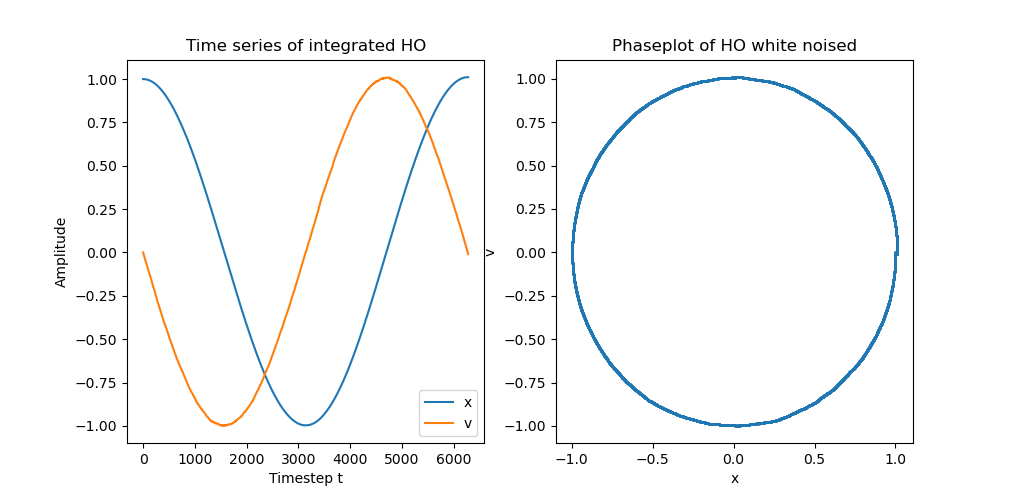

In [160]:
%matplotlib notebook

plt.subplot(121)
plt.plot(x, label='x')
plt.plot(v, label='v')
plt.title('Time series of integrated HO')
plt.xlabel('Timestep t')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(122)
plt.scatter(x, v, s=1, label='phaseplot')
plt.title('Phaseplot of HO white noised')
plt.xlabel('x')
plt.ylabel('v')

plt.show()

#### 2.1.2 Retrieving Drift and Diffusion coefficients

In [199]:
arx = np.linspace(np.min([np.min(v), np.min(x)]),
                  np.max([np.max(v), np.max(x)]), 250)

x_output = [D_1([x, v], 0, [ax, 0], tau=1, bins=15) for ax in arx]
v_output = [D_1([x, v], 1, [0, ax], tau=1, bins=15) for ax in arx]

In [181]:
xx_output = [D_2([x, v], 0, 0, [ax, 0], tau=1, bins=15) for ax in arx]

<IPython.core.display.Javascript object>


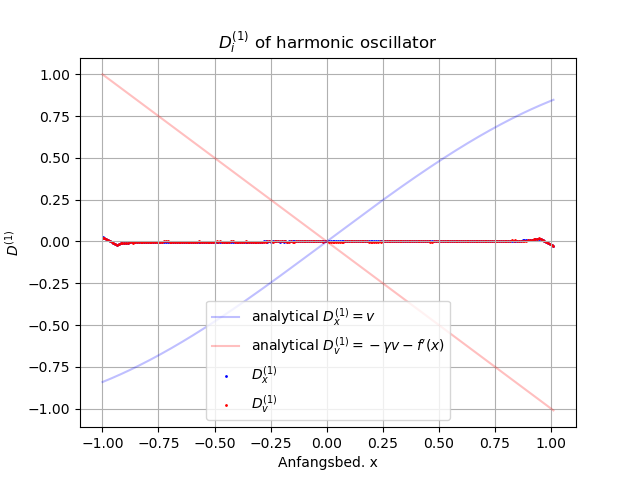

In [201]:
%matplotlib notebook
plt.scatter(arx, [1 * el for el in x_output], s=1, label='$D^{(1)}_x$', c='b')
plt.scatter(arx, [1 * el for el in v_output], s=1, label='$D^{(1)}_v$', c='r')

plt.plot(arx, [np.sin(el) for el in arx], c='b', alpha=0.25, label='analytical $D^{(1)}_x=v$')
plt.plot(arx, [- gamma * np.sin(el) - f(el) for el in arx], c='r', alpha=0.25,
         label='analytical $D^{(1)}_v=-\gamma v -f\'(x)$')

plt.title('$D^{(1)}_i$ of harmonic oscillator')
plt.xlabel('Anfangsbed. x')
plt.ylabel('$D^{(1)}$')
plt.legend()
plt.grid()

plt.show()

# Note that our coefficient equal nearly zero.
# Why is that?
# Our algorithm uses the mean of the upcoming change to the series,
# when it has a certain value.
# Due to the periodical characteristics of the sinusoid the mean change
# will be at any time zero, if we run the series long enough.
# On the other Hand, those coefficients should not equal zero -> wtf
# Should mean be quadratic? Is D calculated differently when two dimensions
# are present?

#### 2.1.3 Reconstructing time series

In [164]:
dt = 0.1
T = 100
n = int(T / dt)
sqrtdt = np.sqrt(dt)

x_ = []
v_ = []
x_ = np.zeros(n)
v_ = np.zeros(n)
x_[0] = 0.75
v_[0] = -0.5

for i in range(n - 1):
    x_[i + 1] = x_[i]
    v_[i + 1] = v_[i]
    # 1. Deterministic dynamics
    x_[i + 1] += D_1([x], 0, [x_[i]], tau=1, bins=15) * dt
    v_[i + 1] += D_1([v], 0, [v_[i]], tau=1, bins=15) * dt
    # 2. Stochastic dynamics
    # ToDo: Implement noise amplitudes g_ij() [?] and random gamma. [1](12)
    #x_[i + 1] += sqrtdt * np.random.randn() * epsilon
    #v_[i + 1] += sqrtdt * np.random.randn() * epsilon

<IPython.core.display.Javascript object>


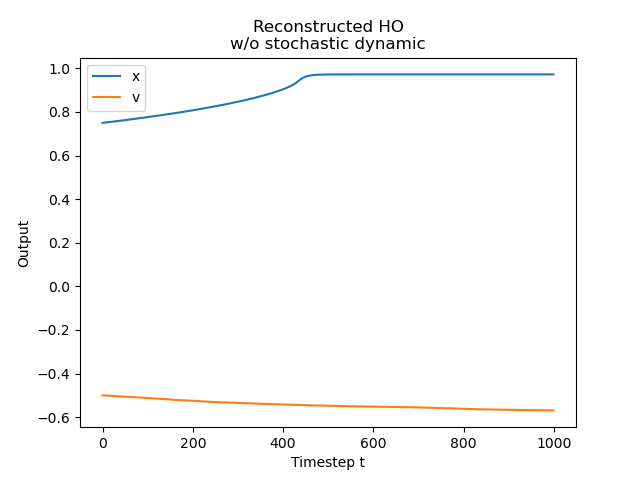

In [165]:
%matplotlib notebook
plt.plot(x_, label='x')
plt.plot(v_, label='v')

plt.title('Reconstructed HO\nw/o stochastic dynamic')
plt.xlabel('Timestep t')
plt.ylabel('Output')
plt.legend()

plt.show()

### 2.2 Langevin telegram signal

#### 2.2.1 Creating time series

In [143]:
dt = 0.001
T = 1000
n = int(T / dt)
sqrtdt = np.sqrt(dt)

gamma = 0.05
epsilon = 0.1

langevin =[]
langevin = np.zeros(n)

for i in range(n - 1):
    langevin[i + 1] = langevin[i] + dt * (epsilon * langevin[i] - langevin[i] ** 3) +\
                      sqrtdt * gamma * np.random.randn()

<IPython.core.display.Javascript object>


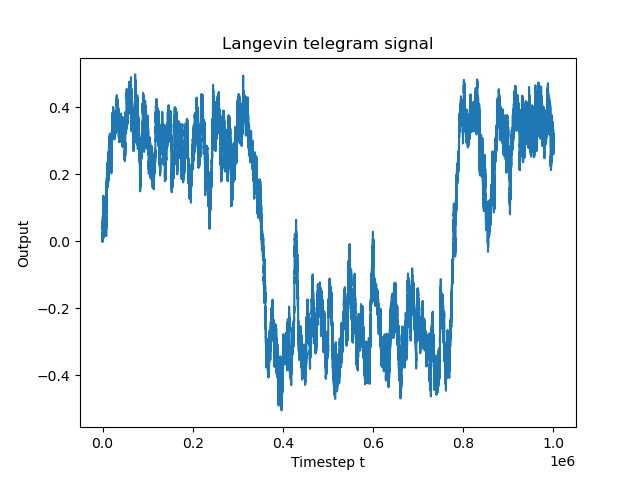

In [168]:
%matplotlib notebook
plt.plot(langevin, label='Langevin')

plt.title('Langevin telegram signal')
plt.xlabel('Timestep t')
plt.ylabel('Output')

plt.show()

#### 2.2.2 Retrieving Drift and Diffusion coefficients

In [145]:
arl = np.linspace(np.min(langevin), np.max(langevin), 250)
# D_1
l_output = [D_1([langevin], 0, [al], tau=1, bins=15) for al in arl]

In [146]:
# D_2
ll_output = [D_2([langevin], 0, 0, [al], tau=1, bins=15) for al in arl]

<IPython.core.display.Javascript object>


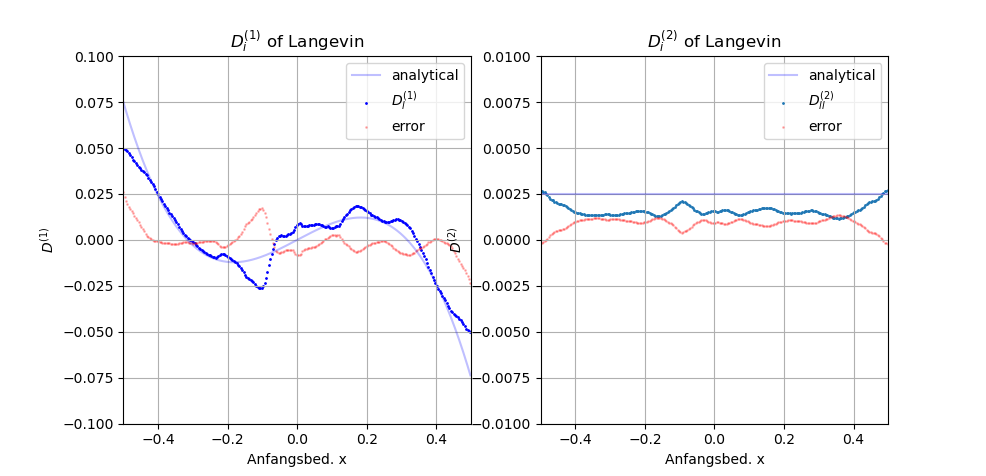

In [147]:
%matplotlib notebook
# Plot D_1 ----------
plt.subplot(121)
plt.scatter(arl, l_output, s=1, label='$D^{(1)}_l$', c='b')
plt.plot(arl, [0.1 * el - el ** 3 for el in arl], c='b', alpha=0.25, label='analytical')

plt.scatter(arl, [((0.1 * arl[i] - arl[i] ** 3) - l_output[i])
                  for i in range(len(l_output))], label="error", c='r', s=1, alpha=0.25)

plt.xlim(-0.5, 0.5)
plt.ylim(-0.1, 0.1)

plt.title('$D^{(1)}_i$ of Langevin')
plt.xlabel('Anfangsbed. x')
plt.ylabel('$D^{(1)}$')
plt.legend()
plt.grid()

# Plot D_2 ----------
plt.subplot(122)
plt.scatter(arl, ll_output, s=1, label='$D^{(2)}_{ll}$')
plt.plot(arl, [0.0025 for _ in arl], c='b', alpha=0.25, label='analytical')

plt.scatter(arl, [((0.0025) - ll_output[i])
                  for i in range(len(ll_output))], label="error", c='r', s=1, alpha=0.25)

plt.xlim(-0.5, 0.5)
plt.ylim(-0.01, 0.01)
plt.title('$D^{(2)}_i$ of Langevin')
plt.xlabel('Anfangsbed. x')
plt.ylabel('$D^{(2)}$')
plt.legend()
plt.grid()

plt.show()

#### 2.2.3 Reconstructing time series

In [ ]:
dt = 0.01
T = 100
n = int(T / dt)
sqrtdt = np.sqrt(dt)

gamma = 0.05

x = np.zeros(n)

for i in range(n - 1):
    x[i + 1] = x[i]
    # 1. Deterministic dynamics
    x[i + 1] += D_1([langevin], 0, [x[i]], tau=1, bins=15) * dt
    # 2. Stochastic dynamics
    x[i + 1] += sqrtdt * np.random.randn() * gamma
    
# ToDo:
# - Implement noise amplitudes g_ij() (above static gamma) [1](12)
# - precalculate D-Terms and approximate
# - Using D_2 where?

In [ ]:
%matplotlib notebook
plt.plot(x, label='Langevin')

plt.title('Reconstructed Langeving telegram signal\nw/ stochastic dynamic')
plt.xlabel('Timestep t')
plt.ylabel('Output')

plt.show()

## Literature

[1] "Analysis of time series from stochastic processes" by J.Gradisek, S.Riegert, R.Freidrich, I.Grabec

[2] "Simulation - Advanced Topics" by A.Greiner as of June 11, 2020

[3] "The Fokker-Planck Equation" by H.Risken as of 1996